In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from binary_btsp_network_torch import BinaryBTSPNetworkTorch
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ---------------- 参数设置 ----------------
n_input = 10000
n_memory = 15000
n_patterns = 13000
fq = 0.0025
fp = 0.005
fw = 0.6

mask_ratios = np.arange(0.0, 1.0, 0.1)
n_repeats = 10
batch_size = 256  # GPU 批量处理大小

# ---------------- 设备 ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ---------------- 初始化网络 ----------------
net = BinaryBTSPNetworkTorch(
    n_input=n_input,
    n_memory=n_memory,
    fq=fq,
    fp=fp,
    fw=fw,
    threshold=8,
    device=device
)

# ---------------- 生成稀疏输入模式并统一 dtype ----------------
patterns = net.make_sparse_patterns(n_patterns).float()  # 转 float32，避免 matmul 错误

# ---------------- 训练网络 ----------------
print("训练网络中...")

batch_size = 64  # 可根据显存调节
n_patterns = patterns.shape[0]

for i in tqdm(range(0, n_patterns, batch_size), desc="Training Patterns"):
    batch_patterns = patterns[i:i+batch_size]  # (B, n_input)
    
    # 遍历 batch 中每个模式，使用向量化更新
    for pat in batch_patterns:
        net.btsp_update_fast(pat)

print("训练完成.")



使用设备: cuda
训练网络中...


Training Patterns: 100%|██████████| 204/204 [00:10<00:00, 19.06it/s]

训练完成.


In [ ]:
n_show = 5  # 要展示的模式数量
patterns_cpu = patterns.cpu().numpy()  # 转到 CPU，方便打印或绘图

print("=== CA3 输入模式示例 ===")
for i in range(n_show):
    active_idx = np.where(patterns_cpu[i] > 0)[0]
    print(f"模式 {i}: 活跃 CA3 神经元索引 ({len(active_idx)} 个): {active_idx[:20]} ...")  # 只显示前 20 个

print("\n=== CA1 输出模式示例 ===")
for i in range(n_show):
    z = net.forward(patterns[i])
    active_idx = np.where(z.cpu().numpy() > 0)[0]
    print(f"模式 {i}: 激活 CA1 神经元 ({len(active_idx)} 个): {active_idx[:20]} ...")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.subplot(2, n_show, i+1)
    plt.imshow(patterns_cpu[i:i+1], cmap='gray', aspect='auto')
    plt.title(f"CA3 输入 {i}")
    plt.axis('off')

    plt.subplot(2, n_show, i+1+n_show)
    z_cpu = net.forward(patterns[i]).cpu().numpy()
    plt.imshow(z_cpu.reshape(1, -1), cmap='gray', aspect='auto')
    plt.title(f"CA1 输出 {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import csv

# 选择模式
pattern_idx = 10
pattern = patterns[pattern_idx]

# 掩码比例列表
mask_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

# 输出文件
csv_file = f"ca1_active_indices_pattern_{pattern_idx}.csv"

with open(csv_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["mask_ratio", "n_active_CA1", "active_CA1_indices"])
    
    for mask_ratio in mask_ratios:
        n_mask = int(mask_ratio * pattern.numel())
        mask = torch.ones_like(pattern)
        if n_mask > 0:
            mask_idx = torch.randperm(pattern.numel(), device=pattern.device)[:n_mask]
            mask[mask_idx] = 0

        pattern_masked = pattern * mask
        z = net.forward(pattern_masked)
        active_idx = torch.nonzero(z, as_tuple=True)[0].cpu().numpy()
        
        # 写入 CSV，active_idx 转成字符串
        writer.writerow([mask_ratio, len(active_idx), ",".join(map(str, active_idx))])

print(f"已将 CA1 激活索引保存到 {csv_file}")


In [ ]:

# ---------------- 计算不同掩码下的记忆保留 ----------------
print("计算不同掩码比例下的平均相对不相似度...")
mean_rel_diss = []

for mask_ratio in tqdm(mask_ratios, desc="Mask Ratios"):
    rel_diss_list = []

    for _ in tqdm(range(n_repeats), desc=f"Repeats (mask_ratio={mask_ratio:.2f})", leave=False):
        # 随机打乱 pattern
        perm = torch.randperm(n_patterns, device=device)
        patterns_shuffled = patterns[perm]

        # 分批处理
        for i in range(0, n_patterns, batch_size):
            batch_patterns = patterns_shuffled[i:i+batch_size]
            B = batch_patterns.shape[0]

            # 原输出
            z_orig = (net.synaptic_strengths @ batch_patterns.T) >= net.threshold[:, None]
            z_orig = z_orig.to(torch.uint8)

            # 构造掩码
            n_mask = int(mask_ratio * batch_patterns.shape[1])
            if n_mask > 0:
                mask_idx = torch.stack([torch.randperm(batch_patterns.shape[1], device=device)[:n_mask] for _ in range(B)])
                mask = torch.ones((B, batch_patterns.shape[1]), device=device)
                mask[torch.arange(B)[:, None], mask_idx] = 0
                batch_masked = batch_patterns * mask
            else:
                batch_masked = batch_patterns

            # 掩码输出
            z_masked = (net.synaptic_strengths @ batch_masked.T) >= net.threshold[:, None]
            z_masked = z_masked.to(torch.uint8)

            # 随机其他 pattern 输出
            rand_idx = torch.randint(0, n_patterns, (B,), device=device)
            rand_idx = torch.where(rand_idx >= i, rand_idx + 1, rand_idx) % n_patterns
            pattern_rand = patterns[rand_idx]
            z_rand = (net.synaptic_strengths @ pattern_rand.T) >= net.threshold[:, None]
            z_rand = z_rand.to(torch.uint8)

            # 海明距离（不同位数）
            hd_same = (z_orig != z_masked).float().sum(dim=0)
            hd_rand = (z_orig != z_rand).float().sum(dim=0)
            print(hd_same,hd_rand)
            # 相对差异（可选归一化）
            rel = hd_same / (hd_rand + 1e-8)
            rel_diss_list.append(rel.cpu().numpy())

    rel_diss_list_flat = np.concatenate(rel_diss_list)
    mean_rel_diss.append(rel_diss_list_flat.mean())


# ---------------- 绘制结果 ----------------
plt.figure(figsize=(6, 4))
plt.plot(mask_ratios, mean_rel_diss, marker='o', color='blue')
plt.xlabel("Mask Ratio")
plt.ylabel("Relative Dissimilarity")
plt.title("Memory Retention under Different Mask Ratios")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Computing baseline outputs: 100%|██████████| 204/204 [00:01<00:00, 142.69it/s]


Baseline average active CA1 per pattern (no mask): 82.0289
计算不同掩码比例下的平均归一化海明距离...


Mask Ratios: 100%|██████████| 10/10 [04:26<00:00, 26.61s/it]


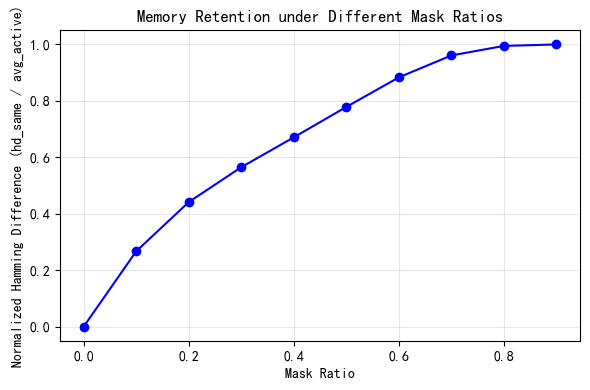

In [2]:
# ---------------- 预计算：无掩码下所有 pattern 的 CA1 输出与平均活跃神经元数 ----------------
all_active_counts = []
for i in tqdm(range(0, n_patterns, batch_size), desc="Computing baseline outputs"):
    batch_patterns = patterns[i:i+batch_size]
    z_all_batch = (net.synaptic_strengths @ batch_patterns.T) >= net.threshold[:, None]
    z_all_batch = z_all_batch.to(torch.uint8)
    active_counts = z_all_batch.sum(dim=0).cpu().numpy()  # 每个pattern活跃CA1数量
    all_active_counts.append(active_counts)

all_active_counts = np.concatenate(all_active_counts)
avg_active = float(all_active_counts.mean())
print(f"Baseline average active CA1 per pattern (no mask): {avg_active:.4f}")

# ---------------- 计算不同掩码下的记忆保留 ----------------
print("计算不同掩码比例下的平均归一化海明距离...")
mean_rel_diss = []

for mask_ratio in tqdm(mask_ratios, desc="Mask Ratios"):
    rel_diss_list = []

    for _ in tqdm(range(n_repeats), desc=f"Repeats (mask_ratio={mask_ratio:.2f})", leave=False):
        # 随机打乱 pattern
        perm = torch.randperm(n_patterns, device=device)
        patterns_shuffled = patterns[perm]

        for i in range(0, n_patterns, batch_size):
            batch_patterns = patterns_shuffled[i:i+batch_size]
            B = batch_patterns.shape[0]

            # 原输出
            z_orig = (net.synaptic_strengths @ batch_patterns.T) >= net.threshold[:, None]
            z_orig = z_orig.to(torch.uint8)

            # 构造掩码
            n_mask = int(mask_ratio * batch_patterns.shape[1])
            if n_mask > 0:
                mask_idx = torch.stack([
                    torch.randperm(batch_patterns.shape[1], device=device)[:n_mask]
                    for _ in range(B)
                ])
                mask = torch.ones((B, batch_patterns.shape[1]), device=device)
                mask[torch.arange(B)[:, None], mask_idx] = 0
                batch_masked = batch_patterns * mask
            else:
                batch_masked = batch_patterns

            # 掩码输出
            z_masked = (net.synaptic_strengths @ batch_masked.T) >= net.threshold[:, None]
            z_masked = z_masked.to(torch.uint8)

            # 计算掩码前后海明距离（不同位数）
            hd_same = (z_orig != z_masked).float().sum(dim=0)  # 每个 pattern 的差异数
            rel = hd_same / (avg_active + 1e-8)  # 归一化到平均活跃数
            rel_diss_list.append(rel.cpu().numpy())

    # 汇总平均
    rel_diss_list_flat = np.concatenate(rel_diss_list)
    mean_rel_diss.append(rel_diss_list_flat.mean())

# ---------------- 绘制结果 ----------------
plt.figure(figsize=(6, 4))
plt.plot(mask_ratios, mean_rel_diss, marker='o', color='blue')
plt.xlabel("Mask Ratio")
plt.ylabel("Normalized Hamming Difference (hd_same / avg_active)")
plt.title("Memory Retention under Different Mask Ratios")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
